# Building heights by distance from a point

by Chris Prince [chrprince@gmail.com] - 12 May 2018

Similar analysis for NYC as for the plots shown in this tweet:
https://twitter.com/geographyjim/status/994949659461341184

![building heights by distance for London and Paris](https://pbs.twimg.com/media/Dc7FSwFXkAA5-br.jpg:large)

### Imports:

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.wkt import loads
import pylab as pl
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
buildings = pd.read_csv('/home/cmp/data/building.csv')
#buildings = pd.read_csv('/home/cmp/data/chicago_buildings.csv')

### Sources

**NYC**: https://data.cityofnewyork.us/Housing-Development/Building-Footprints/nqwf-w8eh/data

Similar data exists for Chicago, but appears incomplete: https://data.cityofchicago.org/Buildings/Building-Footprints-deprecated-August-2015-/qv97-3bvb (and the current version may be broken) as of 12 May 2018.

In [4]:
buildings.head()

,the_geom,NAME,CNSTRCT_YR,BIN,LSTMODDATE,LSTSTATYPE,DOITT_ID,HEIGHTROOF,FEAT_CODE,GROUNDELEV,SHAPE_AREA,SHAPE_LEN
0,MULTIPOLYGON (((-73.81023637428498 40.72623326...,NaN,1993,4441987,12/19/2017 12:00:00 AM +0000,Constructed,1283366,21.540000,2100,70,1089.812313,166.785929
1,MULTIPOLYGON (((-73.86002815218995 40.57354222...,NaN,1920,4518072,08/17/2017 12:00:00 AM +0000,Constructed,964744,16.381832,5110,6,329.898503,77.673856
2,MULTIPOLYGON (((-73.76711333552652 40.61130961...,NaN,1940,4299860,08/22/2017 12:00:00 AM +0000,Constructed,547717,26.795523,2100,8,1234.856322,146.929814
3,MULTIPOLYGON (((-73.74704802666373 40.60410892...,NaN,1930,4516837,08/17/2017 12:00:00 AM +0000,Constructed,861127,11.358426,5110,29,275.411758,68.476327
4,MULTIPOLYGON (((-73.77058283711517 40.59512166...,NaN,1931,4301765,08/22/2017 12:00:00 AM +0000,Constructed,288652,26.632714,2100,6,1420.221189,208.893121


Create the geometries from the wkt column:

In [5]:
geometry = [loads(x) for x in buildings.the_geom]

In [6]:
b = gpd.geodataframe.GeoDataFrame(buildings, geometry=geometry)

Convert the dataframe CRS from lat/long to xy-coordinates (epsg 2263)

In [7]:
b.crs = {'init' :'epsg:4326'}

In [8]:
b = b.to_crs({'init' : 'epsg:2263'})

Calculate centroids of the geometries

In [9]:
b['centroid'] = b.geometry.centroid

In [10]:
from shapely.geometry import Point

The coordinates for Times Square (per Google):

In [11]:
ts = Point(-73.9851,40.7589)

Some gymnastics to convert the lat/long of TS to our CRS

In [12]:
ts = gpd.geodataframe.GeoDataFrame([ts])
ts.geometry = ts[0]
ts.crs = ({'init' : 'epsg:4326'})
ts = ts.to_crs({'init' : 'epsg:2263'})
tsft = ts.geometry

Distance calculations are done from the geometry attribute of the GeoDataFrame, so set the geometry to the centroid column:

In [13]:
b.geometry = b.centroid

In [14]:
b['dist'] = b.distance(tsft[0])

In [15]:
ftPerMeter = 3.28084

In [16]:
b['dist_m'] = b['dist']/ftPerMeter

In [17]:
b['HEIGHTROOF_m'] = b['HEIGHTROOF']/ftPerMeter

Use seaborn defaults to emulate look of the source plots:

In [18]:
sns.set()

Drop zero-height entries and cutoff after 25 km:

In [19]:
b = b[b.HEIGHTROOF>0]
b_25k = b[b.dist_m<25000]

I don't bother clipping at 50m, since there is some structure up there that might be interesting. Here's the plot similar to those above for London and Paris:

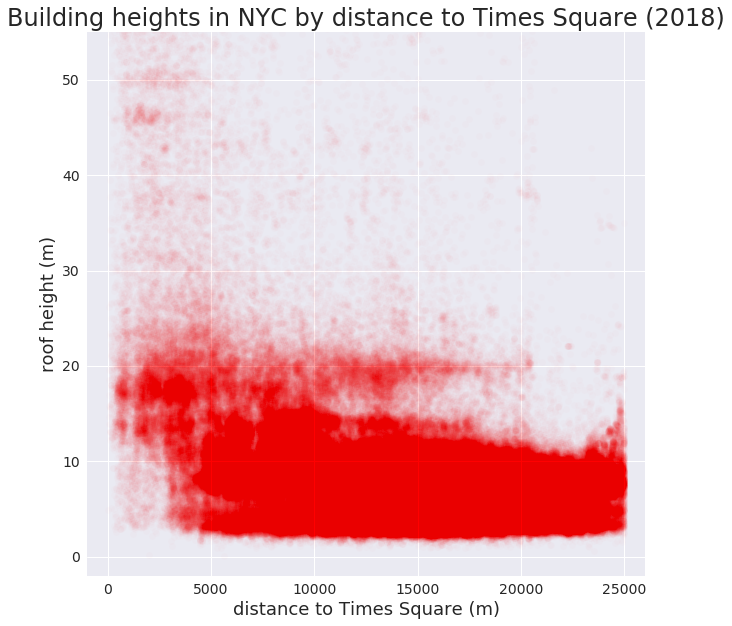

In [20]:
fig, ax=pl.subplots(figsize=(10,10))
pl.plot(b_25k.dist_m, b_25k.HEIGHTROOF_m, 'o', color = 'r', alpha=0.01)
ax.set_xlim((-1000,26000))
ax.set_ylim((-2,55))
pl.xticks(fontsize=14)
pl.yticks(fontsize=14)
ax.set_title("Building heights in NYC by distance to Times Square (2018)", size=24)
ax.set_ylabel("roof height (m)", size=18)
ax.set_xlabel("distance to Times Square (m)", size=18)
pl.savefig('nyc_bheights.png', bbox_inches='tight')


Looking up to 200 meters, there is a smaller peak of very tall buildings at 6 km, which looks to be downtown Manhattan.

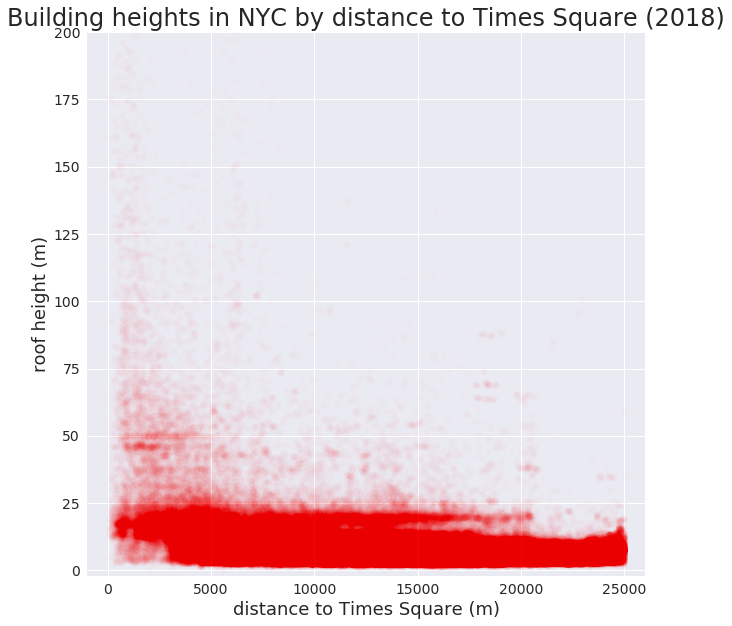

In [21]:
fig, ax=pl.subplots(figsize=(10,10))
pl.plot(b_25k.dist_m, b_25k.HEIGHTROOF_m, 'o', color = 'r', alpha=0.01)
ax.set_xlim((-1000,26000))
ax.set_ylim((-2,200))
pl.xticks(fontsize=14)
pl.yticks(fontsize=14)
ax.set_title("Building heights in NYC by distance to Times Square (2018)", size=24)
ax.set_ylabel("roof height (m)", size=18)
ax.set_xlabel("distance to Times Square (m)", size=18)

Finally, including the population of buildings beyond 25km and clipping height at 30 m, and redicing the opacity to discern more structure. Note the sudden reduction in buildings below ~7 meters past 25 km: the only part of NYC further than 25 km from Times Square is the southern half of Staten Island.

Some thoughts on why this might be:
* This part of Staten is almost exclusively residential. The far parts of the Bronx and Queens between 15 and 25 km out from Times Square are pretty residential too, but they may have more low-slung commercial buildings (e.g., strip malls, drive-thru restaurants) than southern Staten Island. 
* Also, while both areas are heavily reliant on cars, it seems (from cursory inspection of satellite views of both areas) car garages in Queens are largely seperate smaller buildings (which may be present in this data; this set is for buildings, not tax lots like in PLUTO), whereas garages are attached in Staten Island.
* Or, it could simply be that the data was recorded differently in Staten Island, causing shorter structures not to be included here.

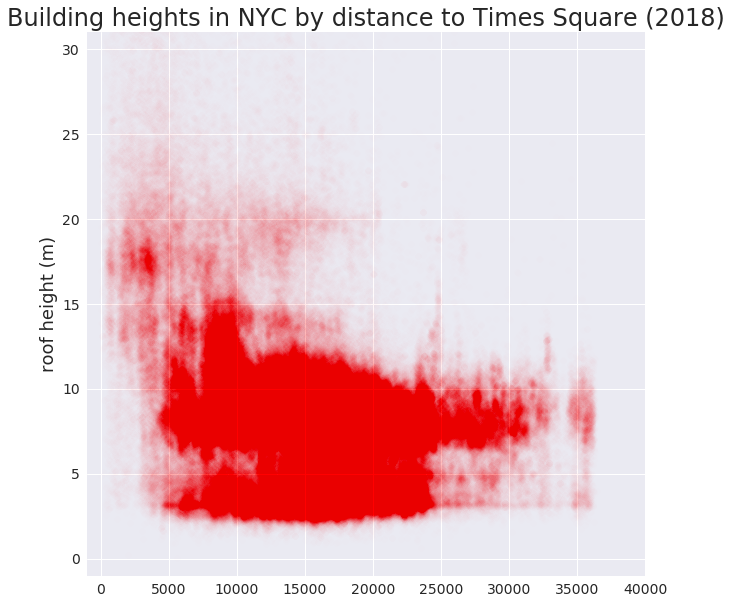

In [22]:
fig, ax=pl.subplots(figsize=(10,10))
pl.plot(b.dist_m, b.HEIGHTROOF_m, 'o', color = 'r', alpha=0.0025)
ax.set_xlim((-1000,40000))
ax.set_ylim((-1,31))
pl.xticks(fontsize=14)
pl.yticks(fontsize=14)
ax.set_title("Building heights in NYC by distance to Times Square (2018)", size=24)
ax.set_ylabel("roof height (m)", size=18)
pl.savefig('nyc_bheights_all.png', bbox_inches='tight')